In [2]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Load necessary files
labevents = pd.read_csv('mimic-iii-clinical-database-1.4/LABEVENTS.csv/LABEVENTS.csv')
patients = pd.read_csv('mimic-iii-clinical-database-1.4/PATIENTS.csv/PATIENTS.csv')
admissions = pd.read_csv('mimic-iii-clinical-database-1.4/ADMISSIONS.csv/ADMISSIONS.csv')
icustays = pd.read_csv('mimic-iii-clinical-database-1.4/ICUSTAYS.csv/ICUSTAYS.csv')
outputevents = pd.read_csv('mimic-iii-clinical-database-1.4/OUTPUTEVENTS.csv/OUTPUTEVENTS.csv')

Extracting creatinine values...
Extracting urine output...
Creating patient timeline...
Calculating patient age...
Processing creatinine measurements...
Processing urine output...
Defining AKI cases using KDIGO criteria...
Creating final dataset...
Engineering features...
Training prediction model...
Evaluating model...

Confusion Matrix:
[[7549    2]
 [   5 2405]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7551
         1.0       1.00      1.00      1.00      2410

    accuracy                           1.00      9961
   macro avg       1.00      1.00      1.00      9961
weighted avg       1.00      1.00      1.00      9961


AUC-ROC Score: 0.9999976920426576

Top 10 features for AKI prediction:
                 Feature  Importance
6           ABS_INCREASE    0.409038
9          URINE_PER_24H    0.211829
5           PCT_INCREASE    0.173625
8            TOTAL_URINE    0.084825
4              MAX_CREAT

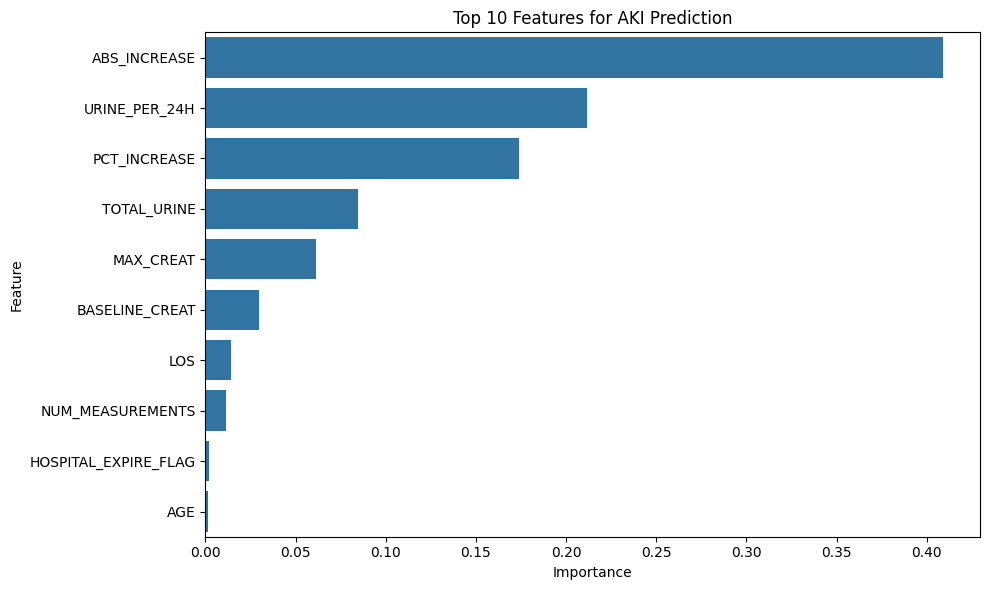


AKI prevalence in the dataset: 23.81%


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# 1. Extract relevant features for AKI prediction

# Get creatinine lab results - ITEMID 50912 is for serum creatinine
print("Extracting creatinine values...")
creatinine_ids = [50912]  # Serum creatinine
creatinine_labs = labevents[labevents['ITEMID'].isin(creatinine_ids)]

# Get urine output from outputevents - important for AKI detection
print("Extracting urine output...")
urine_output_ids = [40055, 43175, 40069, 40094, 40715, 40473, 40085, 40057, 40056, 40405, 40428, 40086, 40096, 40651, 226559]
urine_output = outputevents[outputevents['ITEMID'].isin(urine_output_ids)]

# 2. Merge datasets to create patient timeline
print("Creating patient timeline...")
# Get patient demographics
patient_data = patients[['SUBJECT_ID', 'GENDER', 'DOB']]

# Merge with admissions to get admission information
patient_admits = pd.merge(patient_data, admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'HOSPITAL_EXPIRE_FLAG']], 
                        on='SUBJECT_ID', how='inner')

# Merge with ICU stays
patient_icu = pd.merge(patient_admits, icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'OUTTIME', 'LOS']], 
                     on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# 3. Calculate patient age
# 3. Calculate patient age - with error handling
print("Calculating patient age...")
# First convert dates safely with error handling
patient_icu['DOB'] = pd.to_datetime(patient_icu['DOB'], errors='coerce')
patient_icu['ADMITTIME'] = pd.to_datetime(patient_icu['ADMITTIME'], errors='coerce')

# Filter out rows with null dates
patient_icu = patient_icu.dropna(subset=['DOB', 'ADMITTIME'])

# Check for unrealistic dates and filter them out
# MIMIC-III adds a random offset to dates but keeps them in reasonable range
# Filter out patients born before 1800 or admitted before 2000
patient_icu = patient_icu[patient_icu['DOB'].dt.year > 1800]
patient_icu = patient_icu[patient_icu['ADMITTIME'].dt.year > 2000]

# Make sure ADMITTIME is after DOB
patient_icu = patient_icu[patient_icu['ADMITTIME'] > patient_icu['DOB']]

# Safely calculate age 
patient_icu['AGE'] = (patient_icu['ADMITTIME'].dt.year - patient_icu['DOB'].dt.year)
# Adjust for birthdays that haven't occurred yet this year
birthdays_not_passed = ((patient_icu['ADMITTIME'].dt.month < patient_icu['DOB'].dt.month) | 
                        ((patient_icu['ADMITTIME'].dt.month == patient_icu['DOB'].dt.month) & 
                         (patient_icu['ADMITTIME'].dt.day < patient_icu['DOB'].dt.day)))
patient_icu.loc[birthdays_not_passed, 'AGE'] -= 1

# Filter for adult patients
patient_icu = patient_icu[(patient_icu['AGE'] >= 18) & (patient_icu['AGE'] <= 100)]
# 4. Calculate baseline creatinine and track changes for each ICU stay
print("Processing creatinine measurements...")
creatinine_labs['CHARTTIME'] = pd.to_datetime(creatinine_labs['CHARTTIME'])
baseline_creatinine = []

for idx, stay in patient_icu.iterrows():
    patient_creat = creatinine_labs[(creatinine_labs['SUBJECT_ID'] == stay['SUBJECT_ID']) & 
                                   (creatinine_labs['CHARTTIME'] >= pd.to_datetime(stay['INTIME'])) &
                                   (creatinine_labs['CHARTTIME'] <= pd.to_datetime(stay['OUTTIME']))]
    
    if len(patient_creat) > 0:
        # Sort by time and get baseline (first measurement)
        patient_creat = patient_creat.sort_values('CHARTTIME')
        baseline = patient_creat.iloc[0]['VALUENUM']
        max_creat = patient_creat['VALUENUM'].max()
        
        # Calculate max percentage increase from baseline
        pct_increase = ((max_creat - baseline) / baseline) * 100 if baseline > 0 else 0
        abs_increase = max_creat - baseline
        
        baseline_creatinine.append({
            'ICUSTAY_ID': stay['ICUSTAY_ID'],
            'SUBJECT_ID': stay['SUBJECT_ID'],
            'BASELINE_CREAT': baseline,
            'MAX_CREAT': max_creat,
            'PCT_INCREASE': pct_increase,
            'ABS_INCREASE': abs_increase,
            'NUM_MEASUREMENTS': len(patient_creat)
        })
    
creatinine_changes = pd.DataFrame(baseline_creatinine)

# 5. Calculate total urine output per 24h periods
print("Processing urine output...")
urine_output['CHARTTIME'] = pd.to_datetime(urine_output['CHARTTIME'])
urine_per_stay = []

for idx, stay in patient_icu.iterrows():
    patient_output = urine_output[(urine_output['SUBJECT_ID'] == stay['SUBJECT_ID']) & 
                                 (urine_output['CHARTTIME'] >= pd.to_datetime(stay['INTIME'])) &
                                 (urine_output['CHARTTIME'] <= pd.to_datetime(stay['OUTTIME']))]
    
    if len(patient_output) > 0:
        # Calculate total and 24h urine output
        total_output = patient_output['VALUE'].sum()
        stay_hours = (pd.to_datetime(stay['OUTTIME']) - pd.to_datetime(stay['INTIME'])).total_seconds() / 3600
        
        if stay_hours >= 24:
            output_per_24h = total_output * (24 / stay_hours)
        else:
            # For stays less than 24h, extrapolate to 24h equivalent
            output_per_24h = total_output * (24 / stay_hours) if stay_hours > 0 else 0
        
        urine_per_stay.append({
            'ICUSTAY_ID': stay['ICUSTAY_ID'],
            'SUBJECT_ID': stay['SUBJECT_ID'],
            'TOTAL_URINE': total_output,
            'URINE_PER_24H': output_per_24h
        })
    
urine_data = pd.DataFrame(urine_per_stay)

# 6. Define AKI based on KDIGO criteria
print("Defining AKI cases using KDIGO criteria...")
# Merge creatinine and urine data
aki_data = pd.merge(creatinine_changes, urine_data, on=['ICUSTAY_ID', 'SUBJECT_ID'], how='outer')

# Apply KDIGO criteria for AKI:
# Stage 1: 1.5-1.9x baseline or ≥0.3 mg/dL increase or urine output <0.5 mL/kg/h for 6-12h
# Stage 2: 2.0-2.9x baseline or urine output <0.5 mL/kg/h for ≥12h
# Stage 3: 3.0x baseline or increase to ≥4.0 mg/dL or urine output <0.3 mL/kg/h for ≥24h or anuria for ≥12h

# For simplicity, we'll just determine AKI vs. no AKI
aki_data['AKI'] = 0
aki_data.loc[(aki_data['PCT_INCREASE'] >= 50) | 
             (aki_data['ABS_INCREASE'] >= 0.3) | 
             (aki_data['URINE_PER_24H'] < 500), 'AKI'] = 1  # Simplified criterion

# 7. Merge with patient data for final dataset
print("Creating final dataset...")
final_data = pd.merge(patient_icu, aki_data, on=['ICUSTAY_ID', 'SUBJECT_ID'], how='inner')

# 8. Feature engineering
print("Engineering features...")
# One-hot encode gender
final_data['GENDER_F'] = (final_data['GENDER'] == 'F').astype(int)

# Create features
model_data = final_data[[
    'AGE', 'GENDER_F', 'LOS', 'BASELINE_CREAT', 'MAX_CREAT', 
    'PCT_INCREASE', 'ABS_INCREASE', 'NUM_MEASUREMENTS', 
    'TOTAL_URINE', 'URINE_PER_24H', 'HOSPITAL_EXPIRE_FLAG', 'AKI'
]].copy()

# Handle missing values
imputer = SimpleImputer(strategy='median')
model_data_imputed = pd.DataFrame(
    imputer.fit_transform(model_data),
    columns=model_data.columns
)

# 9. Train an AKI prediction model
print("Training prediction model...")
# Define features and target
X = model_data_imputed.drop('AKI', axis=1)
y = model_data_imputed['AKI']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 10. Evaluate model
print("Evaluating model...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))

# 11. Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 features for AKI prediction:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features for AKI Prediction')
plt.tight_layout()
plt.show()

# Calculate AKI prevalence
aki_prevalence = y.mean() * 100
print(f"\nAKI prevalence in the dataset: {aki_prevalence:.2f}%")


In [ ]:
# Additional code to restructure data for LSTM with patient limit
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

def create_lstm_ready_dataset(max_patients=15000):
    print(f"Restructuring data for LSTM model (limited to {max_patients} patients)...")
    
    # Instead of aggregating creatinine measurements, preserve the time series
    sequence_data = []
    sequence_labels = []
    
    # Define sequence length (e.g., first 48 hours after ICU admission)
    sequence_hours = 48
    time_step_hours = 4  # 6-hour intervals
    
    # Create a dictionary to track AKI status for each stay
    stay_aki_status = dict(zip(aki_data['ICUSTAY_ID'], aki_data['AKI']))
    
    # Get unique patients and limit to max_patients
    unique_subjects = patient_icu['SUBJECT_ID'].unique()
    if len(unique_subjects) > max_patients:
        # Sample max_patients unique patients
        selected_subjects = np.random.choice(unique_subjects, max_patients, replace=False)
        limited_patients = patient_icu[patient_icu['SUBJECT_ID'].isin(selected_subjects)]
        print(f"Limiting analysis to {max_patients} randomly selected patients out of {len(unique_subjects)}")
    else:
        limited_patients = patient_icu
        print(f"Using all available {len(unique_subjects)} patients (less than the {max_patients} limit)")
    
    # Track processed patients count
    processed_subjects = set()
    last_milestone = 0
    sequences_created = 0
    
    print("Starting patient data processing...")
    
    # Process each ICU stay
    for idx, stay in limited_patients.iterrows():
        subject_id = stay['SUBJECT_ID']
        icustay_id = stay['ICUSTAY_ID']
        intime = pd.to_datetime(stay['INTIME'])
        
        # Skip if we've already reached the limit
        if len(processed_subjects) >= max_patients:
            break
            
        # Skip if we don't have AKI status
        if icustay_id not in stay_aki_status:
            continue
            
        aki_status = stay_aki_status[icustay_id]
        
        # Get all measurements for this patient during this stay
        patient_creat = creatinine_labs[(creatinine_labs['SUBJECT_ID'] == subject_id) &
                                       (creatinine_labs['CHARTTIME'] >= intime) &
                                       (creatinine_labs['CHARTTIME'] <= intime + pd.Timedelta(hours=sequence_hours))]
        
        patient_urine = urine_output[(urine_output['SUBJECT_ID'] == subject_id) &
                                    (urine_output['CHARTTIME'] >= intime) &
                                    (urine_output['CHARTTIME'] <= intime + pd.Timedelta(hours=sequence_hours))]
        
        # Skip patients with insufficient data
        if len(patient_creat) < 2:
            continue
            
        # Create a time grid with regular intervals
        time_grid = [intime + pd.Timedelta(hours=h) for h in range(0, sequence_hours, time_step_hours)]
        
        # Initialize sequence with NaN values
        # Features: [creatinine, urine_output, hours_since_admission]
        sequence = np.full((len(time_grid), 3), np.nan)
        
        # Fill creatinine values
        for i, time_point in enumerate(time_grid):
            # Find closest creatinine measurement within a window
            time_window = time_step_hours / 2
            closest_creat = patient_creat[(patient_creat['CHARTTIME'] >= time_point - pd.Timedelta(hours=time_window)) &
                                         (patient_creat['CHARTTIME'] < time_point + pd.Timedelta(hours=time_window))]
            
            if len(closest_creat) > 0:
                sequence[i, 0] = closest_creat['VALUENUM'].mean()
            
            # Find urine output in this time window
            hour_urine = patient_urine[(patient_urine['CHARTTIME'] >= time_point) &
                                      (patient_urine['CHARTTIME'] < time_point + pd.Timedelta(hours=time_step_hours))]
            
            if len(hour_urine) > 0:
                sequence[i, 1] = hour_urine['VALUE'].sum()
                
            # Hours since admission
            sequence[i, 2] = i * time_step_hours
        
        # Forward fill and then backward fill NaN values
        sequence_df = pd.DataFrame(sequence)
        sequence_filled = sequence_df.fillna(method='ffill').fillna(method='bfill').values
        
        # If we still have NaNs after filling, skip this sequence
        if np.isnan(sequence_filled).any():
            continue
            
        # Add to our dataset
        sequence_data.append(sequence_filled)
        sequence_labels.append(aki_status)
        processed_subjects.add(subject_id)
        sequences_created += 1
        
        # Print progress update every 1000 patients
        current_count = len(processed_subjects)
        if current_count >= last_milestone + 1000:
            last_milestone = (current_count // 1000) * 1000
            print(f"Processed {current_count} patients, created {sequences_created} sequences...")
    
    print(f"Created sequences for {len(processed_subjects)} unique patients with {len(sequence_data)} total sequences")
    
    # Convert to numpy arrays
    X_seq = np.array(sequence_data)
    y_seq = np.array(sequence_labels)
    
    # Scale features
    print("Scaling features...")
    scaler = MinMaxScaler()
    n_samples, n_timesteps, n_features = X_seq.shape
    X_seq_reshaped = X_seq.reshape(n_samples * n_timesteps, n_features)
    X_seq_scaled = scaler.fit_transform(X_seq_reshaped).reshape(n_samples, n_timesteps, n_features)
    
    print("Dataset preparation complete!")
    return X_seq_scaled, y_seq
# LSTM implementation using PyTorch
class AKILSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(AKILSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = torch.nn.Dropout(0.2)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Get the output from the last time step
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        out = self.sigmoid(out)
        
        return out


max_patients=15000
print(f"Preparing sequential data for up to {max_patients} patients...")
X_seq, y_seq = create_lstm_ready_dataset(max_patients)


Preparing sequential data for up to 15000 patients...
Restructuring data for LSTM model (limited to 15000 patients)...
Limiting analysis to 15000 randomly selected patients out of 36521
Starting patient data processing...
Processed 1000 patients, created 1373 sequences...
Processed 2000 patients, created 2727 sequences...
Processed 3000 patients, created 4044 sequences...
Processed 4000 patients, created 5359 sequences...
Processed 5000 patients, created 6737 sequences...
Processed 6000 patients, created 8071 sequences...
Processed 7000 patients, created 9339 sequences...
Processed 8000 patients, created 10608 sequences...
Processed 9000 patients, created 11877 sequences...
Processed 10000 patients, created 13097 sequences...
Processed 11000 patients, created 14320 sequences...
Processed 12000 patients, created 15562 sequences...
Processed 13000 patients, created 16786 sequences...
Created sequences for 13159 unique patients with 16983 total sequences
Scaling features...
Dataset prepar

In [26]:

# Print dataset statistics
print(f"Dataset shape: {X_seq.shape}, Labels: {np.bincount(y_seq.astype(int))}")
aki_rate = np.mean(y_seq) * 100
print(f"AKI rate in dataset: {aki_rate:.1f}%")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 64
num_layers = 5
output_size = 1
learning_rate = 0.001
batch_size = 32
num_epochs = 100 # Reduced epochs since we have fewer patients

# Initialize model
model = AKILSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Training LSTM model...")
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluate model
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test_tensor).numpy().flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    print("\nLSTM Model Evaluation:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nAUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))


Dataset shape: (16983, 12, 3), Labels: [12770  4213]
AKI rate in dataset: 24.8%
Training LSTM model...
Epoch [5/100], Loss: 0.4131
Epoch [10/100], Loss: 0.3874
Epoch [15/100], Loss: 0.3832
Epoch [20/100], Loss: 0.3778
Epoch [25/100], Loss: 0.3757
Epoch [30/100], Loss: 0.3725
Epoch [35/100], Loss: 0.3691
Epoch [40/100], Loss: 0.3654
Epoch [45/100], Loss: 0.3640
Epoch [50/100], Loss: 0.3596
Epoch [55/100], Loss: 0.3561
Epoch [60/100], Loss: 0.3562
Epoch [65/100], Loss: 0.3562
Epoch [70/100], Loss: 0.3496
Epoch [75/100], Loss: 0.3511
Epoch [80/100], Loss: 0.3442
Epoch [85/100], Loss: 0.3399
Epoch [90/100], Loss: 0.3374
Epoch [95/100], Loss: 0.3348
Epoch [100/100], Loss: 0.3300

LSTM Model Evaluation:
Confusion Matrix:
[[2475  102]
 [ 350  470]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2577
           1       0.82      0.57      0.68       820

    accuracy                           0.87      3397
   mac

In [29]:
# After evaluation, set the model back to training mode
model.train()

# Define additional training parameters
additional_epochs = 30
print(f"\nContinuing training for {additional_epochs} more epochs...")

# Continue training loop
for epoch in range(num_epochs, num_epochs + additional_epochs):
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs + additional_epochs}], Loss: {running_loss/len(train_loader):.4f}')

model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test_tensor).numpy().flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    print("\nLSTM Model Evaluation:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nAUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))



Continuing training for 30 more epochs...
Epoch [105/130], Loss: 0.3246
Epoch [110/130], Loss: 0.3247
Epoch [115/130], Loss: 0.3162
Epoch [120/130], Loss: 0.3116
Epoch [125/130], Loss: 0.3067
Epoch [130/130], Loss: 0.3109

LSTM Model Evaluation:
Confusion Matrix:
[[2480   97]
 [ 363  457]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2577
           1       0.82      0.56      0.67       820

    accuracy                           0.86      3397
   macro avg       0.85      0.76      0.79      3397
weighted avg       0.86      0.86      0.85      3397


AUC-ROC Score: 0.8313062551463699
